# Autocorrelation function to detect seasonality

The idea of this notebook is to clarify some notions of autocorrelation function. I've encountered autocorrelation function many times in various contexts. Previously, I've also used velocity autocorrelation function and residence time autocorrelation function to characterize ion mobilities in MD simulations. But I understand only the math of it. As I read more about autocorrelation, I find there are actually two main fields that have the same notion: signal processing and statistic. They share many similarities when expressing the term, but have some slight differences as well.

I will walk you through an examples, where I will show you some python implementations to compute autocorrelation and visualize autocorrelation plot. There will also be discussion after the example that illustrates the difference between each implementation.

In short, there are several functions claim that could calculate autocorrelation function, the comparison is shown in the table below:

|function|definition|
|-|-|
|pandas.plotting.autocorrelation_plot|$C(\tau)=\frac{1}{N}\sum\limits_{t=1}^{N-\tau}(Y_t-\bar{Y})(Y_{t+\tau}-\bar{Y})$|
|numpy.correlate        |$C(\tau)=\sum_{t=1}^{N-\tau}(Y_t)(Y_{t+\tau})$|
|matplotlib.pyplot.acorr|$C(\tau)=\sum_{t=1}^{N-\tau}(Y_t)(Y_{t+\tau})$|
|numpy.corrcoef         |Pearson Correlation Coefficients|
|pandas.autocorr        |&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Pearson Correlation Coefficients|



References:

1. [Autocorrelation Plot from NIST](https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm)
1. [Autocorrelation from wikipedia](https://en.wikipedia.org/wiki/Autocorrelation)
1. [Pearson Correlation Coefficient from wikipedia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot

## Read data for CO2 concentration

The data is from [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4411.htm), which showes the CO2 concentration at Mauna Loa Observatory from 1974 to 1987. Since CO2 concentration has seasonality, this data set is very useful to illustrate autocorrelation in data.

In [2]:
df = pd.read_csv('MLCO2MON.DAT', skiprows = [1], sep = '\s+')

In [3]:
df.head()

,CO2,Year&Month,Year,Month
0,333.13,1974.38,1974,5
1,332.09,1974.46,1974,6
2,331.10,1974.54,1974,7
3,329.14,1974.63,1974,8
4,327.36,1974.71,1974,9


## A glance of the data by run sequence plot

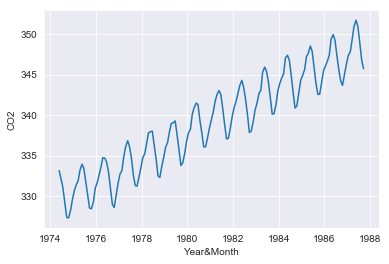

In [4]:
sns.lineplot(x='Year&Month', y='CO2', data=df)

Obviously there's seasonality in the plot, but it's hard to determine the period of the seasonality. Thus, we need autocorrelation to find out the season period.

But before that, we also noticed that the data also has a trend. We will  try to eliminate the trend first, by simply linear fitting.

In [5]:
params = np.polyfit(df['Year&Month'], df['CO2'], deg = 1)
fun_fit = np.poly1d(params)

co2_shifted = df.apply(lambda x: x['CO2']-fun_fit(x['Year&Month']), axis = 1)

### See how how well is the linear fitting

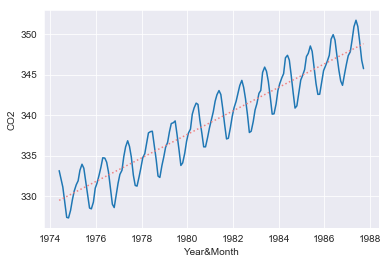

In [6]:
sns.lineplot(x='Year&Month', y='CO2', data=df)
plt.plot(df['Year&Month'], fun_fit(df['Year&Month']), ':', color = 'lightcoral')

### Plot with seaborn regplot() to show the confidence interval

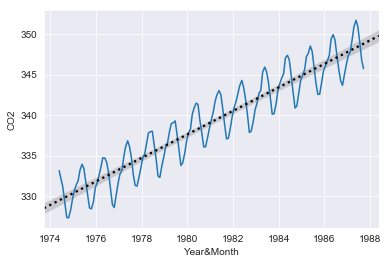

In [7]:
sns.lineplot(x='Year&Month', y='CO2', data=df)
sns.regplot(x='Year&Month', y='CO2', data=df, scatter = False,
           line_kws=dict(color='k', linestyle = ':'))

### See the plot after removing the trend

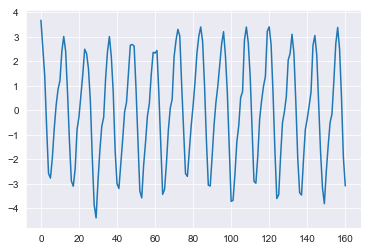

In [8]:
co2_shifted.plot()

There's no obvious trend now.

### This could also be done by residplot()

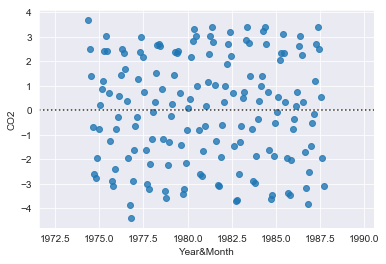

In [9]:
sns.residplot(x='Year&Month', y='CO2', data=df)

## Compute autocorrelation function

### Compute with numpy.correlate()

In [10]:
fullco = np.correlate(co2_shifted, co2_shifted, mode = 'full')
autoco = fullco[len(fullco)//2:]
autoco = autoco/autoco[0]

Text(0, 0.5, 'Autocorrelation')

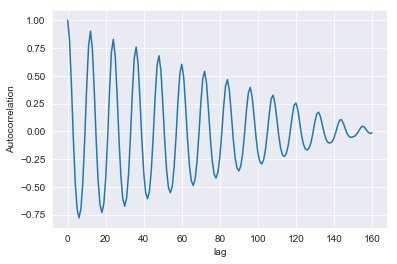

In [11]:
plt.plot(range(len(autoco)), autoco)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')

np.correlate calculates correlation in full range from negative to positive, we only need the positive side.

### Compute with numpy.corrcoeff

In [12]:
corrcoef = [1]
for i in range(1, len(co2_shifted)-1):
    corrcoef.append(np.corrcoef(co2_shifted[:-i], co2_shifted[i:])[0, 1])

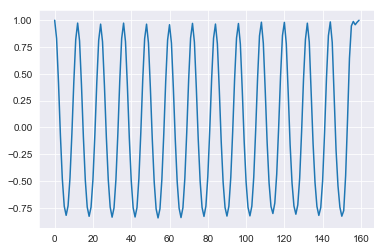

In [13]:
plt.plot(range(len(corrcoef)), corrcoef)

This plot is different from previous one. According to numpy document, corrcoeff calculates Pearson product-moment correlation coefficients. So the sample size for each calculate used here is N-lag, and varies as lag changes.

But both of them showed the periodicity of 12 months.

### Compute pandas.autocorr()

In [14]:
ac = []
for i in range(len(co2_shifted)-1):
    ac.append(co2_shifted.autocorr(i))

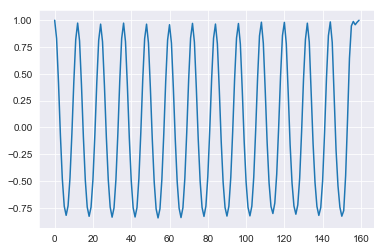

In [15]:
plt.plot(range(len(ac)), ac)

It turns out that autocorr has the same curve with numpy.corrcoef. Again the difference is due to different needs in signal processing and statistics, which will be explained later in this notebook.

One difference is that the autocorrealtion in signal processing is average over all samples N, instead of N-lag in statistics.

To prove that, we multiply back the previous correlation funtion with N-lag and divided by N.

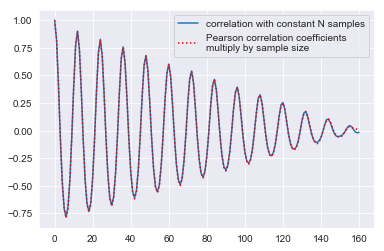

In [16]:
ac_mod = []
for i in range(len(co2_shifted)-1):
    ac_mod.append(co2_shifted.autocorr(i)*(len(co2_shifted)-i)/len(co2_shifted))
plt.plot(range(len(autoco)), autoco, label = 'correlation with constant N samples')
plt.plot(range(len(ac_mod)), ac_mod, 'r:', label = 'Pearson correlation coefficients\nmultiply by sample size')
plt.legend()

Now we can see that the two curves are now more similar.

### Visualize the autocorrelation with pandas's autocorrelation_plot

Pandas provide tools in plotting that can help us easily visualize autocorrelation functions

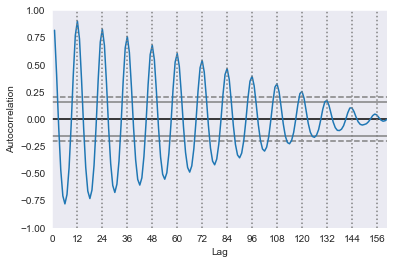

In [17]:
autocorrelation_plot(co2_shifted)
for i in range(1, len(co2_shifted)//12+1):
    plt.plot((12*i, 12*i), (-1, 1), ':', color = 'gray')
plt.xticks(range(0, len(co2_shifted), 12));

We can see that the period is 12 months, as there are obvious peaks every 12 months.

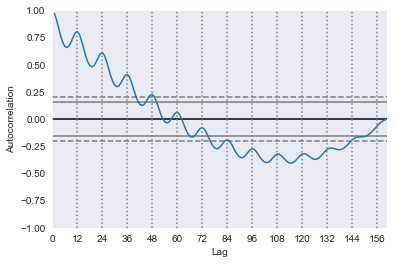

In [18]:
# autocorrelation from original data without removing the trend
autocorrelation_plot(df['CO2'])
for i in range(1, len(co2_shifted)//12+1):
    plt.plot((12*i, 12*i), (-1, 1), ':', color = 'gray')
plt.xticks(range(0, len(co2_shifted), 12));

The autocorrelation from original data is more "slow" in decaying.

### plot using pyplot.acorr()

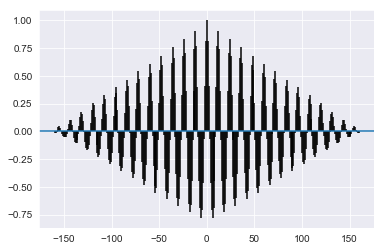

In [19]:
lags, ac, line, b = plt.acorr(co2_shifted, maxlags = None);

acorr() will return the lags, autocorrelate vector, line, and horizontal line.

Note that lags has a length of 2*maxlags+1, starting from -maxlags to maxlags.

We are only interested at the positive side.

### Put all these plots together and check consistency

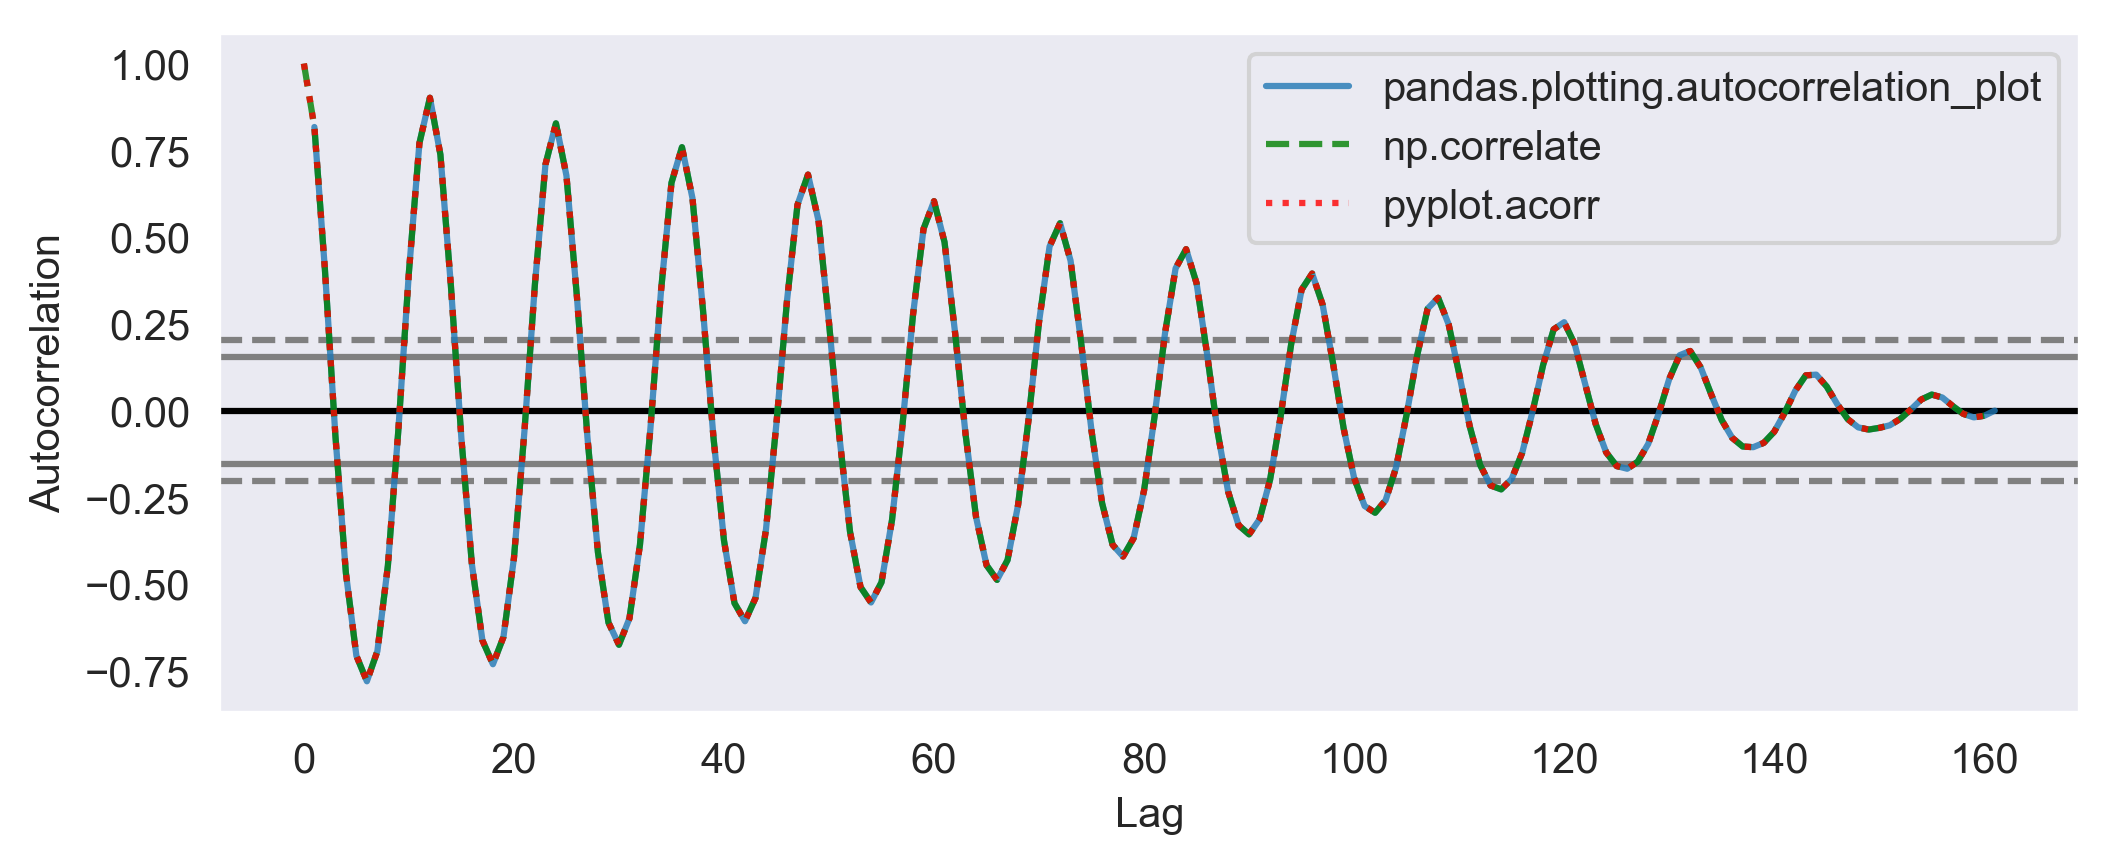

In [20]:
fig = plt.figure(figsize = (8, 3), dpi = 300)
autocorrelation_plot(co2_shifted, label = 'pandas.plotting.autocorrelation_plot', 
                     alpha = 0.8, ax=plt.gca())
plt.plot(range(len(autoco)), autoco, 'g--', alpha = 0.8, label = 'np.correlate')
plt.plot(lags[len(lags)//2:], ac[len(lags)//2:], ':', color = 'r', 
         alpha=0.8, label = 'pyplot.acorr')
plt.legend()

They are identical.

### Another way to visualize the correlation is Lag plot

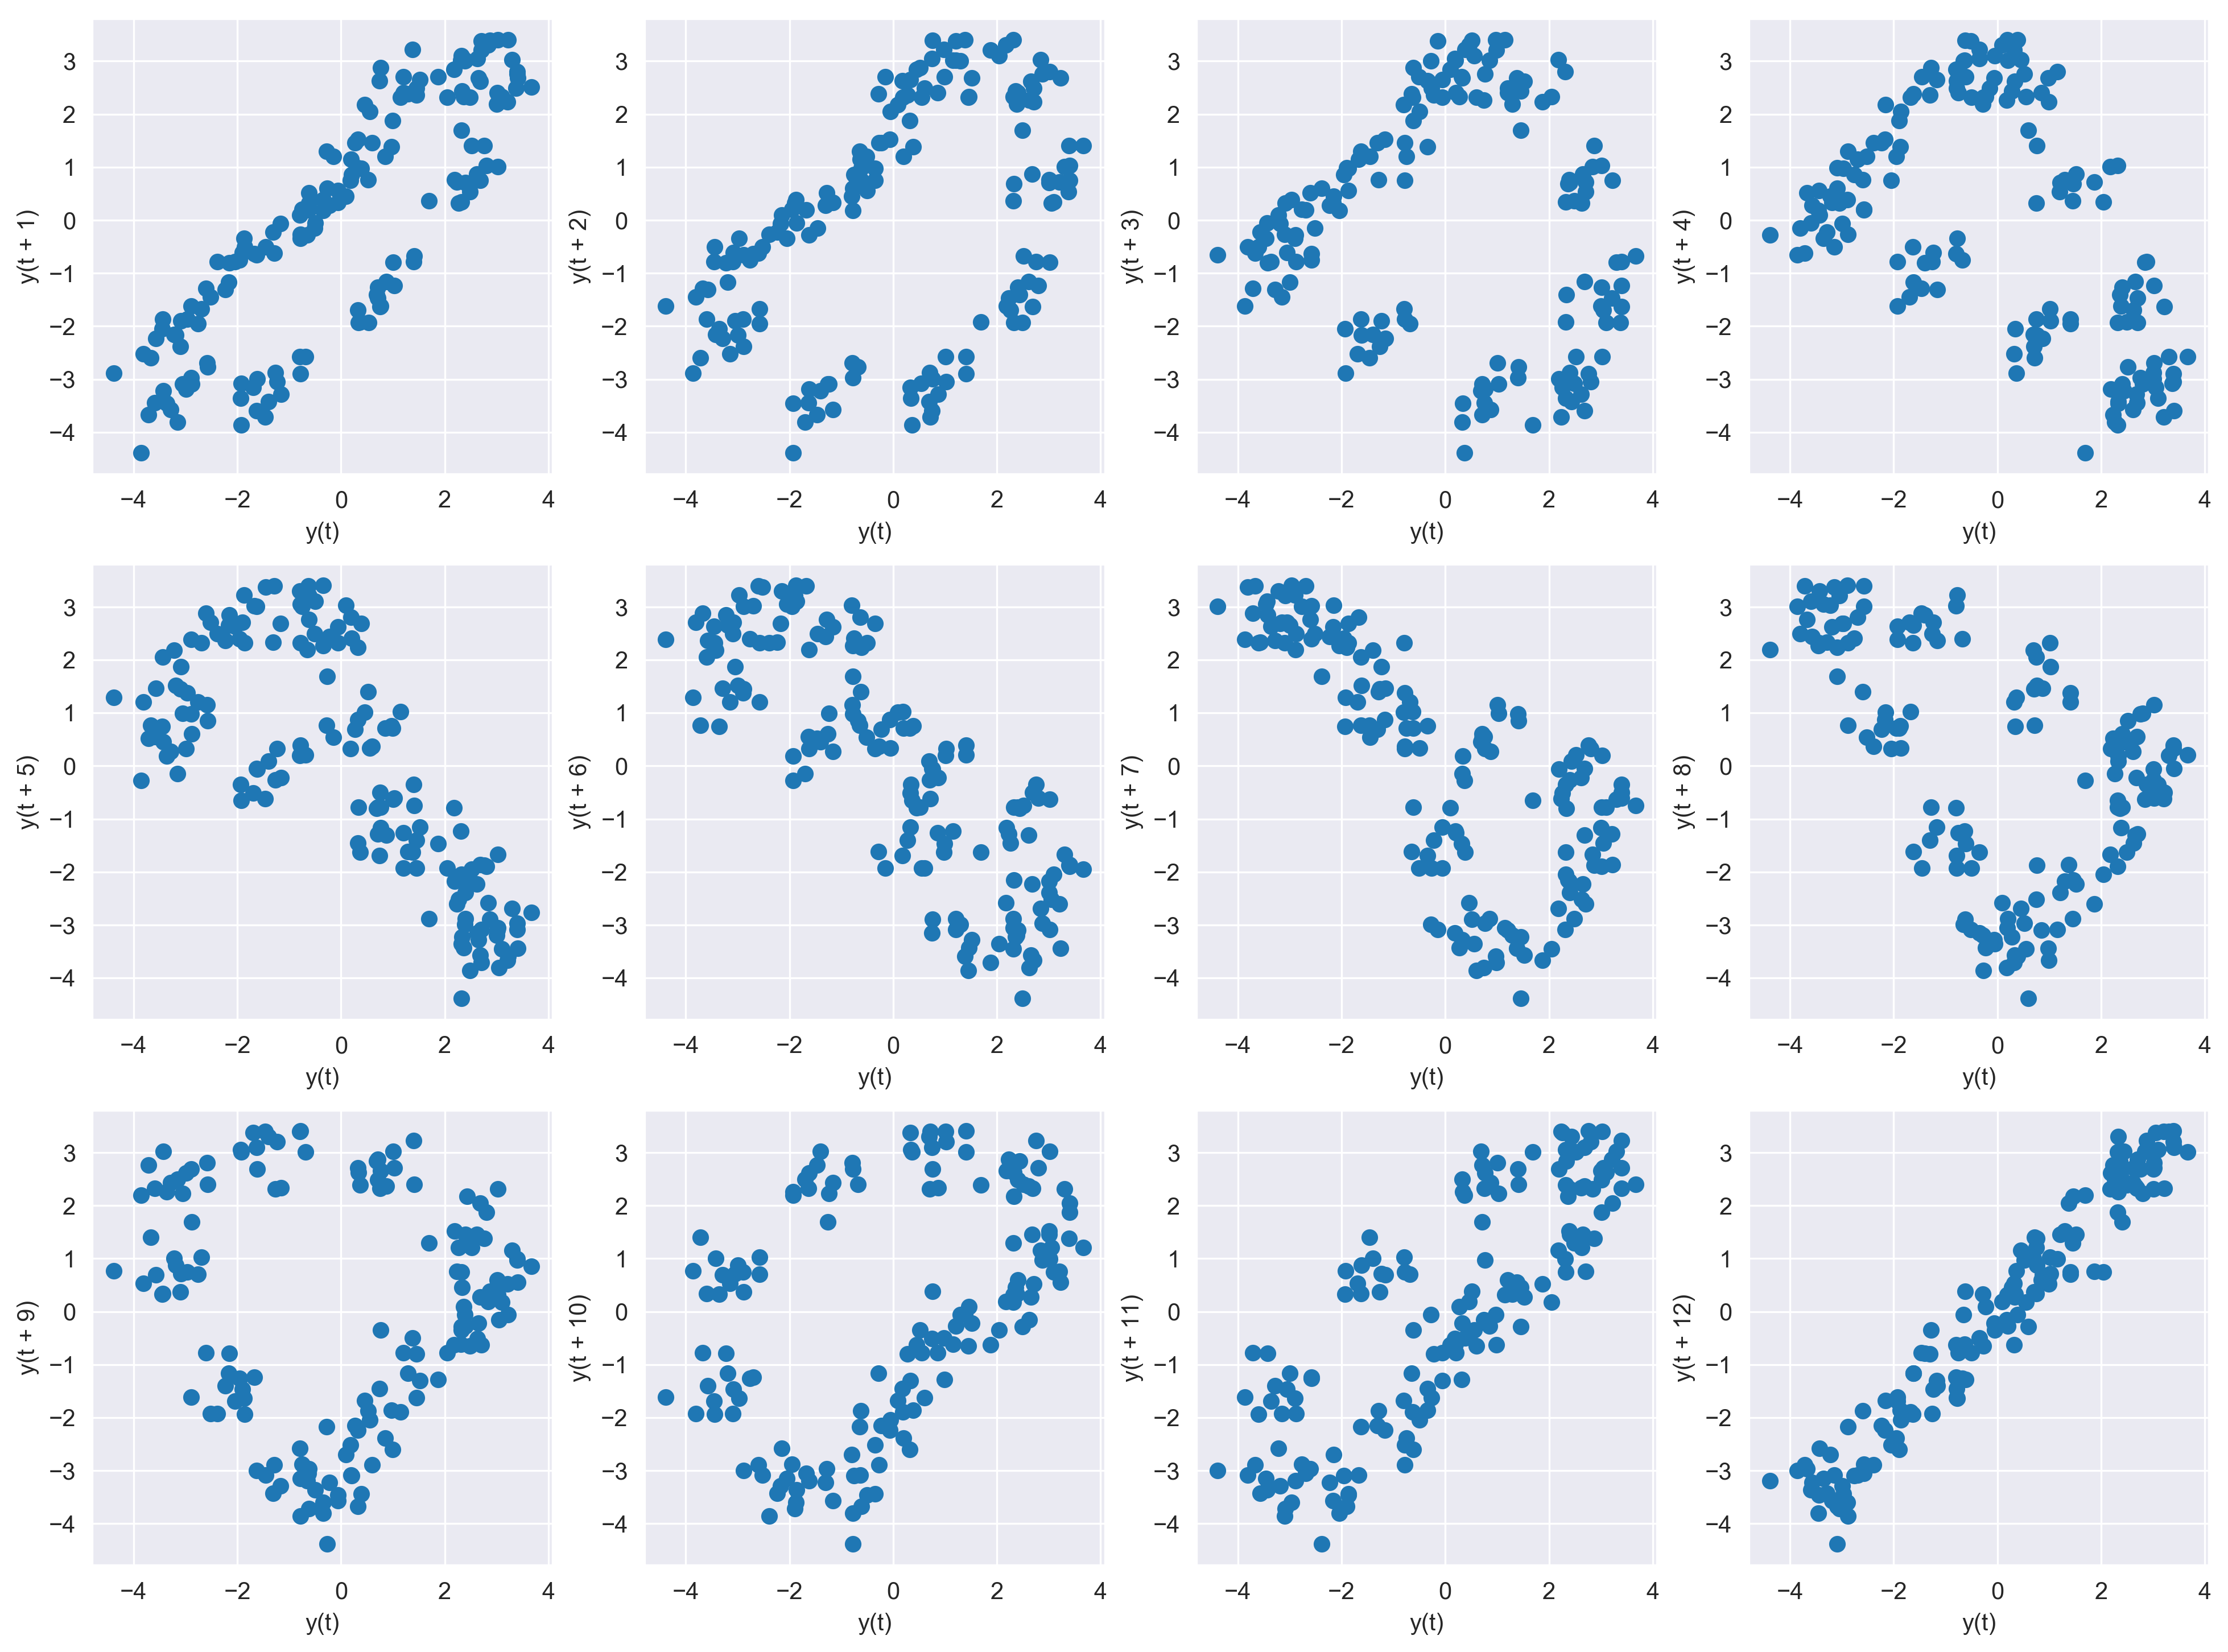

In [21]:
fig, axes = plt.subplots(3, 4, figsize = (16, 12), dpi = 300)
for i in range(12):
    lag_plot(co2_shifted, lag = i+1, ax = axes[i//4][i%4])

We can see that when lag is 12, the correlation is most strong.

## The difference between autocorrelation models

The difference between np.correlate and np.corrcoef is due to the difference in statistics and signal processing. Wikipedia defines the autocorrelation as

$R(\tau)=\frac{E[(X_t-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}$

which is the similar as the Pearson correlation coefficient between values of the same data at different times. But notice here $\hat\mu$ and $\hat\sigma$ used for each calculation does change for different subset of data. **So using Pearson correlation coefficients does not match this equation exactly!** Especially when lag is large, there might be considerable deviation of residue mean and variance.

Wikipedia also says that 
>In signal processing, the above definition is often used without the normalization, that is, without subtracting the mean and dividing by the variance. When the autocorrelation function is normalized by mean and variance, it is sometimes referred to as the autocorrelation coefficient or autocovariance function.

The defintion from NIST is slightly different:

$R(\tau)=\frac{C(\tau)}{C(0)}$

where

$C(\tau)=\frac{1}{N}\sum_{t=1}^{N-\tau}(Y_t-\bar{Y})(Y_{t+\tau}-\bar{Y})$

and $C(0)$ is the variance

$C(0)=\frac{\sum_{t=1}^{N}(Y_t-\bar{Y})^2}{N}$

As we can see, the previous definition uses expectation of times computed, which means the sample size is $N-\tau$ for each $\tau$. However, NIST's definition is averaged over all N samples, which will make the autocorrelation automatics decrease the lag increases. This explains why the autocorrelation computed by np.correlate() showed an decreasing trend, while np.corrcoef did not.

It's also worth noting that NIST also mentions that 
> some sources may use the following formular for the autovariance function:
>
> $C(\tau)=\frac{1}{N-\tau}\sum_{t=1}^{N-\tau}(Y_t-\bar{Y})(Y_{t+\tau}-\bar{Y})$
>
> Althgouth this definition has less bias, the (1/N) formulation has some desirable statistical properties and is the form most commonly used in statistics literature.

"Desirable statistical properties" need more reference...

## Extreme cases to show the difference

### Constant data points

In [22]:
a = np.ones(100)

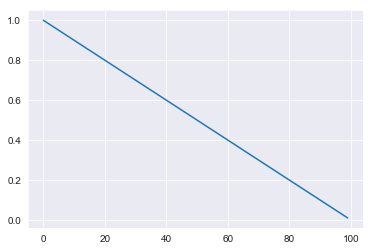

In [23]:
ac_nist = np.correlate(a, a, mode = 'full')
ac_nist = ac_nist[len(ac_nist)//2:]
ac_nist = ac_nist/ac_nist[0]
plt.plot(range(len(ac_nist)), ac_nist);

This extreme case shows that if the data is totally correlated, the autocorrelation will be a line with negative slope ended up with 1/N.

Can't use np.corrcoef or pd.acorr to compute because the variance is 0, nor can the autocorrelation_plot.

### Linear data

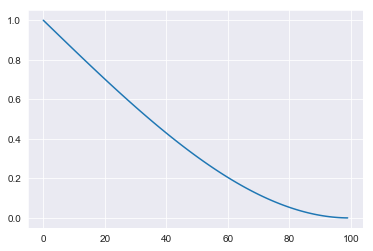

In [24]:
b = pd.Series(np.arange(100))
ac_nist = np.correlate(b, b, mode = 'full')
ac_nist = ac_nist[len(ac_nist)//2:]
ac_nist = ac_nist/ac_nist[0]
plt.plot(range(len(ac_nist)), ac_nist);

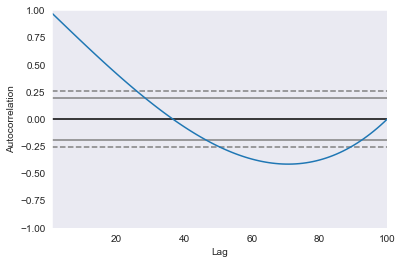

In [25]:
autocorrelation_plot(b)

This plot generated from autocorrelation_plot is different from np.correlate!

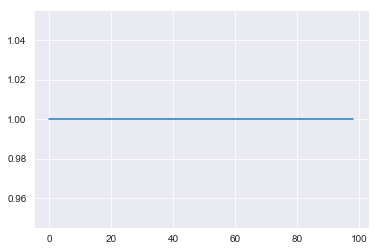

In [26]:
ac_wiki = []
for i in range(len(b)-1):
    ac_wiki.append(b.autocorr(i))
plt.plot(range(len(ac_wiki)), ac_wiki)

Flat line for this less biased autocorrelation.

### Random values

In [27]:
c = pd.Series(np.random.rand(100))

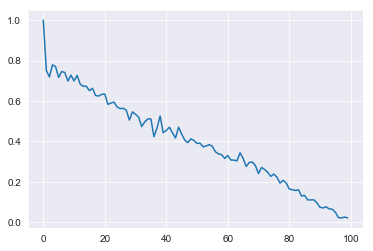

In [28]:
ac_nist = np.correlate(c, c, mode = 'full')
ac_nist = ac_nist[len(ac_nist)//2:]
ac_nist = ac_nist/ac_nist[0]
plt.plot(range(len(ac_nist)), ac_nist);

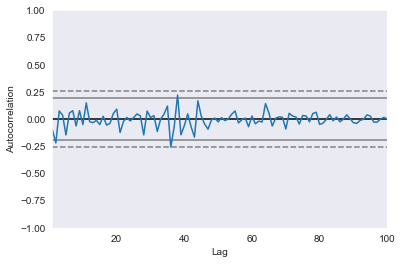

In [29]:
autocorrelation_plot(c)

Autocorrelation_plot is again different from np.correlate()

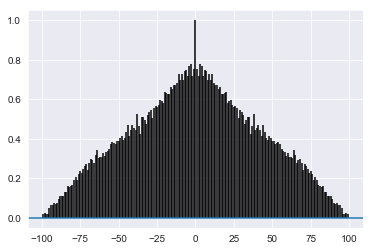

In [30]:
l_c, ac_c, line, b_b = plt.acorr(c, maxlags = None);

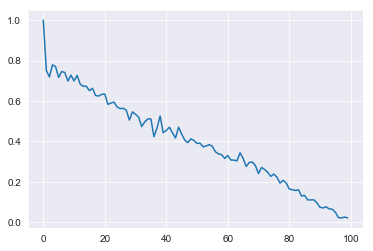

In [31]:
plt.plot(l_c[len(l_c)//2:], ac_c[len(l_c)//2:])

**The pyplot.acorr calculates the same correlation with np.correlate()**

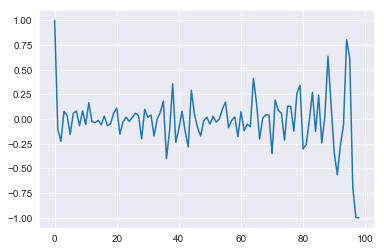

In [32]:
ac_wiki = []
for i in range(len(c)-1):
    ac_wiki.append(c.autocorr(i))
plt.plot(range(len(ac_wiki)), ac_wiki)

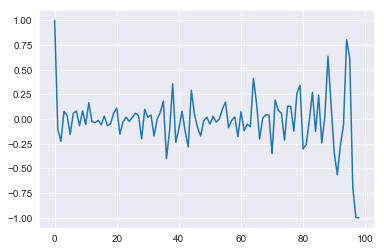

In [33]:
ac_p = [1]
for i in range(1, len(c)-1):
    ac_p.append(np.corrcoef(c[:-i], c[i:])[0, 1])
plt.plot(range(len(ac_p)), ac_p)

**pd.autocorr is identical to numpy.corrcoef, they both calculate pearson correlation coefficients!**

## Check what do these functions do exactly

### Manually implement NIST definition

In [34]:
def calc_autocorr(data, norm = True):
    '''This function calculate the exact autocorrelation function
    using NIST definition.
    If norm is set to false, no normalization
    
    Input
        data: numpy.array
        norm: boolean, default is True
    return
        numpy.array
    '''
    if norm:
        r = [1]
        avg = np.mean(data)
        var = np.var(data)
        for i in range(1, len(data)):
            r.append(sum((data[:-i]-avg)*(data[i:]-avg))/var/len(data))
    else:
        r = [np.sum(data**2)]
        for i in range(1, len(data)):
            r.append(sum((data[:-i])*(data[i:])))
    return np.array(r)

In [35]:
my_nist = calc_autocorr(c.values)

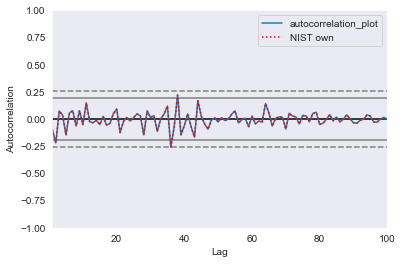

In [36]:
autocorrelation_plot(c, label = 'autocorrelation_plot')
plt.plot(range(len(my_nist)), my_nist, 'r:', label = 'NIST own')
plt.legend()

**autocorrelation_plot uses NIST definition!**

In [37]:
nist_no_norm = calc_autocorr(c.values, norm = False)

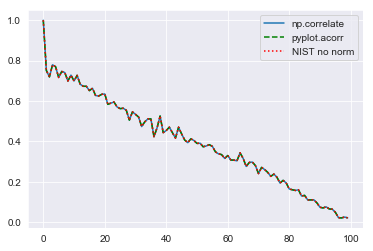

In [38]:
plt.plot(range(len(ac_nist)), ac_nist, label = 'np.correlate');
plt.plot(l_c[len(l_c)//2:], ac_c[len(l_c)//2:], 'g--', label = 'pyplot.acorr')
plt.plot(range(len(nist_no_norm)), nist_no_norm/max(nist_no_norm), 'r:', 
         label = 'NIST no norm')
plt.legend()

**np.correlate and pyplot.acorr use NIST definition but not normalized**

### Manually implement Wikipedia's definition

In [39]:
def calc_autocorr_wiki(data):
    '''This function calculate the exact autocorrelation function
    using NIST definition.
    If norm is set to false, no normalization
    
    Input
        data: numpy.array
    return
        numpy.array
    '''
    r = [1]
    avg = np.mean(data)
    var = np.var(data)
    for i in range(1, len(data)):
        r.append(np.mean((data[:-i]-avg)*(data[i:]-avg))/var)
    return np.array(r)

In [40]:
my_wiki = calc_autocorr_wiki(c.values)

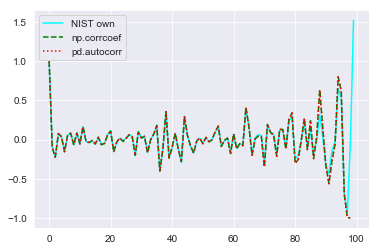

In [41]:
plt.plot(range(len(my_wiki)), my_wiki, '-', color = 'cyan', label = 'NIST own')
plt.plot(range(len(ac_p)), ac_p, 'g--', label = 'np.corrcoef')
plt.plot(range(len(ac_wiki)), ac_wiki, 'r:', label = 'pd.autocorr')
plt.legend()

We can see that these 3 lines are very similar, but still not exactly the same.

In [42]:
np.array((my_wiki[:5], ac_p[:5], ac_wiki[:5])).T

array([[ 1.        ,  1.        ,  1.        ],
       [-0.10256458, -0.1033115 , -0.1033115 ],
       [-0.22358576, -0.22491016, -0.22491016],
       [ 0.07697909,  0.07747869,  0.07747869],
       [ 0.03682812,  0.03699374,  0.03699374]])

Look at these values we can se that the last two are identical but slightly different from first one.

This is because, when using pearson coefficients, the mean and variance of residue will change. But in wiki's definition, $\mu$ and $\sigma$ is the global value and will not change for each lag.

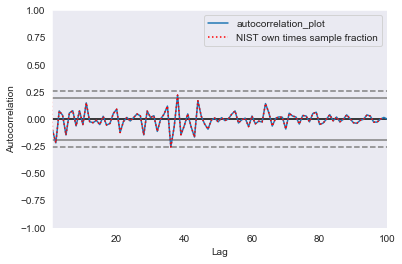

In [43]:
autocorrelation_plot(c, label = 'autocorrelation_plot')
plt.plot(range(len(my_wiki)), my_wiki*np.arange(len(my_wiki), 0, -1)/len(my_wiki),
         ':', color = 'r', label = 'NIST own times sample fraction')
plt.legend()

And we can see, if we multiply back the sample fraction, the autocorrelation function matches with NIST definition

### Pearson Correlation Coefficients as autocorrelation

In [44]:
def calc_autocorr_pearson(data):
    '''This function calculate the exact autocorrelation function
    using NIST definition.
    If norm is set to false, no normalization
    
    Input
        data: numpy.array
    return
        numpy.array
    '''
    r = [1]
    for i in range(1, len(data)-1):
        r.append((np.mean(data[:-i]*data[i:])-np.mean(data[:-i])*np.mean(data[i:]))\
                 /np.sqrt(np.var(data[:-i])*np.var(data[i:])))
    return np.array(r)

In [45]:
my_pearson = calc_autocorr_pearson(c.values)

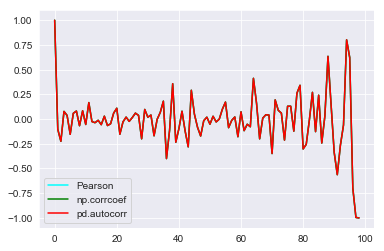

In [46]:
plt.plot(range(len(my_pearson)), my_pearson, '-', color = 'cyan', label = 'Pearson')
plt.plot(range(len(ac_p)), ac_p, 'g-', label = 'np.corrcoef')
plt.plot(range(len(ac_wiki)), ac_wiki, 'r-', label = 'pd.autocorr')
plt.legend()

**Now we can see np.corrcoef and pd.autocorr matches exactly with Pearson correlation coefficients!**

## Summary

We discussed two ways of defining autocorrelation: NIST and wikipedia. The only difference is that NIST uses total sample size for each lag, but wikipedia's definition is less biased and adjust sample size according to lag.

We also compared different python implementations of showing autocorrelation. 

* pandas.plotting.autocorrelation_plot uses NIST original definition
* numpy.correlate and pyplot.acorr also NIST definition but do not do normalization
* np.corrcoef and pandas.Series.autocorr simply use Pearson correlation coefficients as autocorrelation coefficients. Their results are close to Wikipedia's definition, but there's slight deviation.